---

# Построение модели для определения оценочных стоимостей автомобилей на вторичном рынке

---


<u>**Цель проекта**</u>: Создание прототипа модели для оценки стоимости автомобилей на вторичном рынке.

<u>**Сферы деятельности компаний**</u>: продажа автомобилей, интернет-сервисы
площадки объявлений

<u>**Навыки и инструменты**</u>: оценка вычислительной сложности, поиск аномалий, градиентный бустинг, LightGBM

## Описание данных

Признаки:

- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `NotRepaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

Целевой признак:

- `Price` — цена (евро)
<a name="оглавление"></a>

## Оглавление:
1. [Подготовка данных](#подготовка_данных)
2. [Обучение моделей](#обучение_моделей)
3. [Анализ моделей](#анализ_моделей)
4. [Общие выводы](#общие_выводы)

# 1. Подготовка данных
<a name="подготовка_данных"></a>

In [1]:
# %load imports.py

#Основные библиотеки
import pandas as pd
import numpy as np
import math as m
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns

import ipyparallel as ipp

#Параметры визуализации
from pylab import rcParams
%matplotlib inline
%config InlineBackend.figure_format = 'svg' #закомментировать в случае возникновения проблем :)
rcParams['figure.figsize'] = 12, 10
sns.set(rc={'figure.figsize':(14, 10)})

#Параметры отображения результатов выполнения кода в ячейках
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Параметры предупреждений
import warnings
warnings.simplefilter('ignore')

#tqdm
from tqdm.notebook import tqdm

#time
import time 
import datetime

#ML
from sklearn.model_selection import (train_test_split, RandomizedSearchCV, GridSearchCV,
                                     KFold, cross_val_score)

from sklearn.preprocessing import OrdinalEncoder, StandardScaler

from sklearn.utils import shuffle

from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import (LogisticRegression, LinearRegression,
                                  PassiveAggressiveClassifier, Perceptron)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import (accuracy_score, r2_score, f1_score, mean_squared_error,
                             mean_absolute_error, precision_score, recall_score,
                             precision_recall_curve, confusion_matrix, roc_curve, roc_auc_score, 
                             make_scorer)

from sklearn.dummy import DummyClassifier

import joblib

In [2]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [3]:
import lightgbm as lgb

Загрузим и изучим датасет:

In [4]:
data_autos = pd.read_csv(...)

In [5]:
data_autos

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [6]:
data_autos.columns.tolist()

['DateCrawled',
 'Price',
 'VehicleType',
 'RegistrationYear',
 'Gearbox',
 'Power',
 'Model',
 'Kilometer',
 'RegistrationMonth',
 'FuelType',
 'Brand',
 'NotRepaired',
 'DateCreated',
 'NumberOfPictures',
 'PostalCode',
 'LastSeen']

In [7]:
data_autos.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [8]:
data_autos.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [9]:
print('Удалив все объекты с пропусками, мы потеряем {:.1%} всех данных.'
      .format(1-len(data_autos.dropna())/len(data_autos)))

Удалив все объекты с пропусками, мы потеряем 30.6% всех данных.


Один из наиболее критичных признаков — **модель автомобиля**. Тип коробки передач, мощность двигателя и даже тип транспортного средства — косвенные признаки, которые могут лишь указать нам на порядок оценочной стоимости при продаже на вторичном рынке.
Поэтому сразу **ограничим выборку условием: "Указана модель"**.

In [10]:
print('Удалив объекты, для которых отсутствует значение признака "Model", мы потеряем {:.1%} всех данных.'
      .format(1-len(data_autos['Model'].dropna())/len(data_autos)))

Удалив объекты, для которых отсутствует значение признака "Model", мы потеряем 5.6% всех данных.


Более того, причиной пропусков в столбце "Model" могла стать ошибка при извлечении данных. В реальности модель автомобиля указывается почти в 100% случаев.

Среди признаков есть и те, которые потенциально могут снизить эффективность предсказания. К ним можно отнести дату скачивания анкеты из базы (*'DateCrawled'*), месяц регистрации автомобиля (*'RegistrationMonth'*), дату создания анкеты (*'DateCreated'*), количество фотографий автомобиля (*'NumberOfPictures'*), а также дату последней активности пользователя (*'LastSeen'*) и его почтовый индекс (*'PostalCode'*).

In [11]:
data_autos_1_columns = ['Price',
                        'VehicleType',
                        'Brand',
                        'Model',
                        'Gearbox',
                        'FuelType',
                        'Power',
                        'RegistrationYear',
                        'Kilometer',
                        'NotRepaired']


In [12]:
data_autos_1 = pd.DataFrame.copy(data_autos, deep=True)
data_autos_1 = data_autos_1[data_autos_1_columns]
data_autos_1 = data_autos_1[(data_autos_1['Model'].isna() == 0) & (data_autos_1['Price'] != 0)]
data_autos_1

,Price,VehicleType,Brand,Model,Gearbox,FuelType,Power,RegistrationYear,Kilometer,NotRepaired
0,480,NaN,volkswagen,golf,manual,petrol,0,1993,150000,NaN
2,9800,suv,jeep,grand,auto,gasoline,163,2004,125000,NaN
3,1500,small,volkswagen,golf,manual,petrol,75,2001,150000,no
4,3600,small,skoda,fabia,manual,gasoline,69,2008,90000,no
5,650,sedan,bmw,3er,manual,petrol,102,1995,150000,yes
...,...,...,...,...,...,...,...,...,...,...
354362,3200,sedan,seat,leon,manual,petrol,225,2004,150000,yes
354363,1150,bus,opel,zafira,manual,petrol,0,2000,150000,no
354366,1199,convertible,smart,fortwo,auto,petrol,101,2000,125000,no
354367,9200,bus,volkswagen,transporter,manual,gasoline,102,1996,150000,no


In [13]:
data_autos_1.describe()

,Price,Power,RegistrationYear,Kilometer
count,326076.000000,326076.000000,326076.000000,326076.000000
mean,4622.979655,111.985240,2003.949987,128565.518468
std,4530.596984,182.967407,66.756705,37010.622223
min,1.000000,0.000000,1000.000000,5000.000000
25%,1200.000000,71.000000,1999.000000,125000.000000
50%,2950.000000,105.000000,2003.000000,150000.000000
75%,6642.250000,143.000000,2008.000000,150000.000000
max,20000.000000,20000.000000,9999.000000,150000.000000


Видно, что присутствует минимум один автомобиль, которому 1020 лет. Есть автомобили с нулевой мощностью двигателя; почти нулевой стоимостью. Можно убрать все найденные аномалии, однако модели должны обучаться на реальных неидеальных данных, поэтому оставим выбросы в датасете и посмотрим на эффективность обучения.

<div style="border: solid darkcyan 3px; padding: 30px">
    <h3 style="color:black; margin-bottom:25px"> Вывод: </h3>
    <ul>
        <li><b>Загружен датасет, получена общая информация</b>;</li>
        <li><b>Обнаружены пропуски, объяснена возможная причина их появления</b>;</li>
        <li><b>Часть объектов с пропусками исключена из выборки</b>;</li>
        <li><b>Найдены аномальные объекты, принято решение обучать модели на неидеальной выборке</b>.</li>
    </ul>
</div>

[К оглавлению](#оглавление)

# 2. Обучение моделей
<a name="обучение_моделей"></a>

Посмотрим, с какими признаками нам предстоит работать:

In [14]:
data_autos_1.columns.tolist()

['Price',
 'VehicleType',
 'Brand',
 'Model',
 'Gearbox',
 'FuelType',
 'Power',
 'RegistrationYear',
 'Kilometer',
 'NotRepaired']

Для работы с категориальными признаками превратим их в численные прямым кодированием:

In [15]:
data_autos_ohe = pd.get_dummies(data_autos_1, drop_first=True)

features = data_autos_ohe.drop(['Price'], axis=1)
target = data_autos_ohe['Price']

features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=0.25,
                                                                            random_state=12345)

Масштабируем численные признаки, прибегнув к стандартизации:

In [16]:
numeric = ['Power',
           'RegistrationYear',
           'Kilometer']

scaler = StandardScaler().fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Обучим несколько моделей градиентного бустинга с помощью средств библиотеки LightGBM. Используем разные наборы гиперпараметров, чтобы выявить зависимость между конкретными значениями гиперпараметров, скоростью и эффективностью.

Используем LGBMRegressor. В качестве алгоритма выберем градиентный бустинг, в котоом базовыми моделями являются решающие деревья (GBDT).

На этапе регуляризации ограничим параметр *'num_leaves'* в соответствии с рекомендуемой зависимостью от максимальной глубины решающих деревьев:

$$num\_leaves = 2^{max\_depth}$$

Именно от этих двух параметров сильнее всего будет зависеть скорость обучения.

Каждую подвыборку, собираемую из общей выборки объектов, ограничим значением $subsample\_for\_bin = 10000$, а в подвыборки признаков будем включать ровно половину: $feature\_fraction = 0.5$

In [17]:
lgbmr_results = []

for n_estimators in tqdm(range(500, 5001, 500)):
    for max_depth in range(1, 11):
        num_leaves = 2**max_depth
        train_start = time.time()

        model = (lgb.LGBMRegressor(boosting_type='gbdt',
                                   num_leaves=num_leaves,
                                   max_depth=max_depth,
                                   learning_rate=0.1,
                                   feature_fraction=0.5,
                                   n_estimators=n_estimators,
                                   subsample_for_bin=10000,
                                   random_state=12345,
                                   n_jobs=3)
                       .fit(X=features_train, y=target_train))

        train_end = time.time()
        train_time = train_end - train_start
                 
                 
        prediction_start = time.time()
                 
        predictions = model.predict(features_test)
        
        prediction_end = time.time()
        prediction_time = prediction_end - prediction_start
        overall_time = train_time + prediction_time

        
        lgbmr_results.append([num_leaves,
                              max_depth,
                              n_estimators,
                              train_time,
                              prediction_time,
                              overall_time,
                              np.sqrt(mean_squared_error(target_test, predictions))])
        
        print('n_estimators={0}; max_depth={1}; RMSE = {2:.4f}'
              .format(n_estimators, max_depth, np.sqrt(mean_squared_error(target_test, predictions))))

n_estimators=500; max_depth=1; RMSE = 2210.4373
n_estimators=500; max_depth=2; RMSE = 1941.3542
n_estimators=500; max_depth=3; RMSE = 1823.0235
n_estimators=500; max_depth=4; RMSE = 1754.7887
n_estimators=500; max_depth=5; RMSE = 1707.4786
n_estimators=500; max_depth=6; RMSE = 1663.3304
n_estimators=500; max_depth=7; RMSE = 1634.0450
n_estimators=500; max_depth=8; RMSE = 1610.0631
n_estimators=500; max_depth=9; RMSE = 1594.0280
n_estimators=500; max_depth=10; RMSE = 1581.5400
n_estimators=1000; max_depth=1; RMSE = 2148.8985
n_estimators=1000; max_depth=2; RMSE = 1872.3928
n_estimators=1000; max_depth=3; RMSE = 1770.2592
n_estimators=1000; max_depth=4; RMSE = 1700.8528
n_estimators=1000; max_depth=5; RMSE = 1655.1113
n_estimators=1000; max_depth=6; RMSE = 1622.0544
n_estimators=1000; max_depth=7; RMSE = 1601.5013
n_estimators=1000; max_depth=8; RMSE = 1586.2595
n_estimators=1000; max_depth=9; RMSE = 1576.9261
n_estimators=1000; max_depth=10; RMSE = 1569.3347
n_estimators=1500; max_depth

In [18]:
columns = ['num_leaves', 'max_depth', 'n_estimators', 'train_time',
           'prediction_time', 'overall_time', 'RMSE']

lgbmr_results_df = pd.DataFrame(data=lgbmr_results, columns=columns)
lgbmr_results_df

,num_leaves,max_depth,n_estimators,train_time,prediction_time,overall_time,RMSE
0,2,1,500,1.820969,0.444824,2.265793,2210.437270
1,4,2,500,2.088958,0.546538,2.635496,1941.354228
2,8,3,500,2.354441,0.656245,3.010686,1823.023485
3,16,4,500,2.640290,0.800662,3.440952,1754.788670
4,32,5,500,3.017802,0.947683,3.965485,1707.478610
...,...,...,...,...,...,...,...
95,64,6,5000,21.199336,17.820058,39.019394,1578.529309
96,128,7,5000,23.439925,22.095786,45.535711,1574.921812
97,256,8,5000,25.936817,27.410330,53.347147,1569.566337
98,512,9,5000,27.740488,30.432566,58.173054,1567.526628


<div style="border: solid darkcyan 3px; padding: 30px">
    <h3 style="color:black; margin-bottom:25px"> Вывод: </h3>
    <ul>
        <li><b>Категориальные признаки переведены в численные прямым кодированием</b>;</li>
        <li><b>Численные признаки масштабированы стандартизацией</b>;</li>
        <li><b>Произведена регуляризация для уменьшения переобучения моделей градиентного бустинга и времени, необходимого на обучение</b>;</li>
        <li><b>Обучено несколько моделей градиентного бустинга с помощью средств библиотеки LightGBM с использованием разных наборов гиперпараметров</b>.</li>
    </ul>
</div>

[К оглавлению](#оглавление)

# 3. Анализ моделей
<a name="анализ_моделей"></a>

Рассмотрим полученные зависимости:

In [19]:
lgbmr_results_df
lgbmr_results_df.describe()

,num_leaves,max_depth,n_estimators,train_time,prediction_time,overall_time,RMSE
0,2,1,500,1.820969,0.444824,2.265793,2210.437270
1,4,2,500,2.088958,0.546538,2.635496,1941.354228
2,8,3,500,2.354441,0.656245,3.010686,1823.023485
3,16,4,500,2.640290,0.800662,3.440952,1754.788670
4,32,5,500,3.017802,0.947683,3.965485,1707.478610
...,...,...,...,...,...,...,...
95,64,6,5000,21.199336,17.820058,39.019394,1578.529309
96,128,7,5000,23.439925,22.095786,45.535711,1574.921812
97,256,8,5000,25.936817,27.410330,53.347147,1569.566337
98,512,9,5000,27.740488,30.432566,58.173054,1567.526628


,num_leaves,max_depth,n_estimators,train_time,prediction_time,overall_time,RMSE
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,204.600000,5.500000,2750.000000,11.776946,7.434010,19.210956,1679.764958
std,314.544468,2.886751,1443.375673,6.999753,7.829898,14.644638,165.606843
min,2.000000,1.000000,500.000000,1.820969,0.444824,2.265793,1563.941499
25%,8.000000,3.000000,1500.000000,5.999218,2.097155,8.231781,1575.249665
50%,48.000000,5.500000,2750.000000,10.534390,4.163300,14.785059,1605.014786
75%,256.000000,8.000000,4000.000000,16.041725,9.477172,25.675802,1708.194923
max,1024.000000,10.000000,5000.000000,31.228488,37.402523,68.631011,2210.437270


In [20]:
InteractiveShell.ast_node_interactivity = 'last_expr'

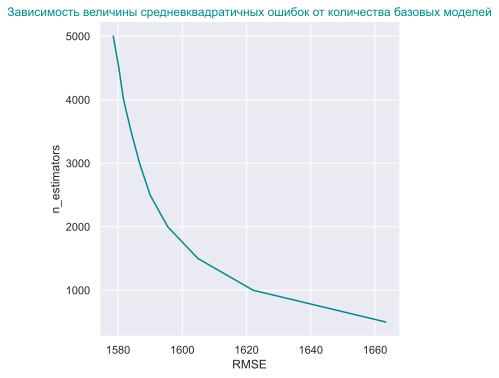

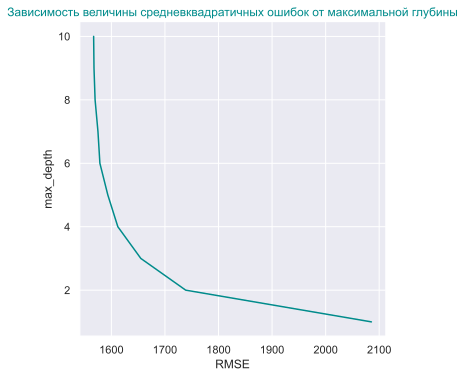

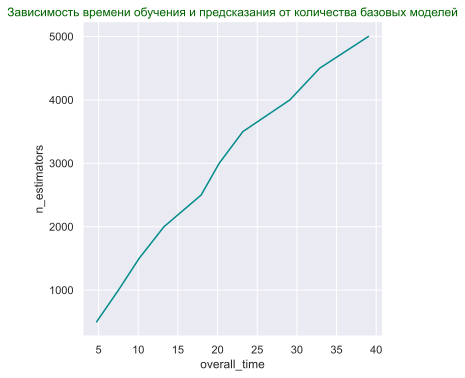

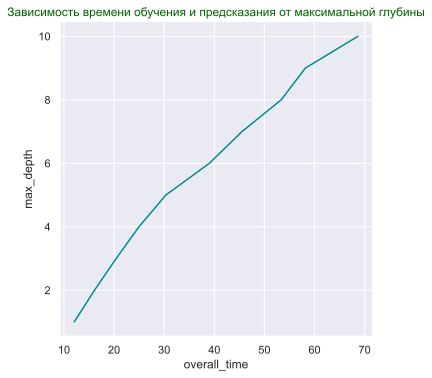

In [21]:
sns.relplot(x='RMSE',
            y='n_estimators',
            kind='line',
            color='darkcyan',
            data=lgbmr_results_df[lgbmr_results_df['max_depth'] == 6])

plt.title("Зависимость величины средневквадратичных ошибок от количества базовых моделей",
          fontsize=12,
          color='darkcyan')

plt.show()

print()

sns.relplot(x='RMSE',
            y='max_depth',
            kind='line',
            color='darkcyan',
            data=lgbmr_results_df[lgbmr_results_df['n_estimators'] == 5000])
plt.title("Зависимость величины средневквадратичных ошибок от максимальной глубины",
          fontsize=12,
          color='darkcyan')
plt.show()

print()

sns.relplot(x='overall_time',
            y='n_estimators',
            kind='line',
            color='darkcyan',
            data=lgbmr_results_df[lgbmr_results_df['max_depth'] == 6])
plt.title("Зависимость времени обучения и предсказания от количества базовых моделей",
          fontsize=12,
          color='darkgreen')
plt.show()

print()

sns.relplot(x='overall_time',
            y='max_depth',
            kind='line',
            color='darkcyan',
            data=lgbmr_results_df[lgbmr_results_df['n_estimators'] == 5000])
plt.title("Зависимость времени обучения и предсказания от максимальной глубины",
          fontsize=12,
          color='darkgreen')
plt.show()


In [22]:
lgbmr_results_df[(lgbmr_results_df['overall_time'] <= 10)
                & (lgbmr_results_df['RMSE'] <= 1700)]

,num_leaves,max_depth,n_estimators,train_time,prediction_time,overall_time,RMSE
5,64,6,500,3.619703,1.128487,4.748190,1663.330423
6,128,7,500,3.681639,1.245177,4.926817,1634.044955
7,256,8,500,4.171911,1.372305,5.544216,1610.063091
8,512,9,500,4.237100,1.465914,5.703013,1594.027958
9,1024,10,500,4.770645,1.616181,6.386827,1581.540049
14,32,5,1000,4.709194,1.797958,6.507153,1655.111266
15,64,6,1000,5.400462,2.100092,7.500555,1622.054383
16,128,7,1000,5.860306,2.410561,8.270867,1601.501291
17,256,8,1000,6.608717,2.771054,9.379771,1586.259514
23,16,4,1500,5.664561,2.000326,7.664887,1668.319416


Видно, что зависимость величины средневквадратичных ошибок от количества базовых моделей и их максимальной глубины близка к логарифмической. Начиная с 2500 базовых моделей и глубины, равной 5, незначительное уменьшение величины средневквадратичной ошибки сопровождается ощутимым увеличением времени обучения и времени предсказания.

[К оглавлению](#оглавление)

<a name="общие_выводы"></a>

<div style="border: solid darkcyan 3px; padding: 30px">
    <h3 style="color:black; margin-bottom:25px"> Общие выводы: </h3>
    <ul>
        <li><b>Загружен датасет, получена общая информация</b>;</li>
        <li><b>На этапе предобработки исключена часть объектов, мешающих обучению моделей</b>;</li>
        <li><b>Аномалии, присутствующие в общей выборке, но не мешающие обучению, не обработаны</b>.</li>
        <li><b>Произведены прямое кодирование, стандартизация и регуляризация</b>;</li>
        <li><b>Обучено несколько моделей градиентного бустинга с помощью средств библиотеки LightGBM с использованием разных наборов гиперпараметров</b>;</li>
        <li><b>Выявлены зависимости между наборами гиперпараметров, эффективностью моделей и временем обучения</b>.</li>
    </ul>
</div>

[К оглавлению](#оглавление)